# Weight range target

Example for 5 units into the future. 

Price example for 10 units: 10, 12, 13, 16, 17, 16, 13, 10, 8, 5

At 10 units, next 5 are 12, 13, 16, 17, 16. Want 16 reduced to 10. Solution: Take difference:

At 10 units, next 5 are 2, 3, 6, 7, 6. (5-pos)/5 weight for each value. 

Highest weighted value - lowest weight value is value proposition (vp). 

Plan: 

map(lambda x, p: ((n-p)/n) * x, list[x], range(len(list(x))))

Then map relative strength using log: ln(vp)/ln(close)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ta.trend import SMAIndicator

In [2]:
# Temporary solution
import sys
sys.path.insert(0, '..')
import useful_functions as uf

In [3]:
df = pd.read_csv("../data/BTCUSDT-hour.csv")

In [4]:
def get_target(df, span=200):
    """gets the balanced value proposition (highest gain over next 200 - lowest low)"""
    acc = []
    df_len = len(df["close"])

    for i in range(len(df["close"])):

        if i+span < df_len:
            close = df["close"].iloc[i]
            c = df["close"][i:i+span]
            a = list(map(lambda x: x-close, c))
            b = list(map(lambda x, p: ((span-p)/span)*x, a, range(span)))
            
            acc.append(uf.log_abs(max(b) + min(b), zeros=True)/uf.log_abs(close))
        else:
            acc.append(None)

    return acc

def get_sma_rate(df, span=50):
    """returns sma rate list"""
    sma_i = SMAIndicator(close=df["close"], window=span)
    sma = sma_i.sma_indicator()
    past = sma.shift(1)
    return list(map(uf.none_subtraction, sma, past))

def dissuade_from_buying_up(df, span=50, limit=0):
    """prevents buying when span sma's slope is greater than limit"""
    df["sma_rate"] = get_sma_rate(df, span)
    return list(map(lambda sma, t: t if sma<limit else -1,df["sma_rate"], df["target"]))

def classify(df, limit:float):
    """return 1 if value is above limit, else 0"""
    return list(map(lambda x: 0 if x<limit else 1, df["target"]))


In [5]:
df["target"] = get_target(df.copy())
df["target"] = dissuade_from_buying_up(df.copy(), 50, 0)
df["target"] = classify(df.copy(), 0.7)
# df["target"] = dissuade_from_buying_up(df, 20, 0)

In [6]:
df

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,target
0,2017-08-17 04:00:00.000,4261.48,4313.62,4261.32,4308.83,47.181009,1502945999999,2.023661e+05,171,35.160503,1.509525e+05,7887.635513,0
1,2017-08-17 05:00:00.000,4308.83,4328.69,4291.37,4315.32,23.234916,1502949599999,1.003048e+05,102,21.448071,9.260828e+04,8039.262402,0
2,2017-08-17 06:00:00.000,4330.29,4345.45,4309.37,4324.35,7.229691,1502953199999,3.128231e+04,36,4.802861,2.079532e+04,8041.760498,0
3,2017-08-17 07:00:00.000,4316.62,4349.99,4287.41,4349.99,4.443249,1502956799999,1.924106e+04,25,2.602292,1.129135e+04,8048.127886,0
4,2017-08-17 08:00:00.000,4333.32,4377.85,4333.32,4360.69,0.972807,1502960399999,4.239504e+03,28,0.814655,3.552747e+03,8018.036500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32885,2021-05-23 09:00:00,34376.00,35300.00,33925.18,34202.58,13905.215271,1621763999999,4.804456e+08,248349,6930.347913,2.395218e+08,0.000000,1
32886,2021-05-23 10:00:00,34207.02,35822.21,34118.72,35004.81,9389.783513,1621767599999,3.293869e+08,179166,4687.146563,1.644107e+08,0.000000,1
32887,2021-05-23 11:00:00,35004.82,35800.00,34600.00,35389.10,6744.387033,1621771199999,2.381694e+08,129096,3263.463404,1.152461e+08,0.000000,1
32888,2021-05-23 12:00:00,35386.80,35800.00,33118.93,33944.77,17222.705813,1621774799999,5.928686e+08,297192,7952.349708,2.739512e+08,0.000000,1


In [25]:
df.to_csv("../data/BTCUSDT-hour-target-old.csv", index=False)

In [2]:
df = pd.read_csv("../data/BTCUSDT-hour-target.csv")

In [3]:
target = df.target

In [18]:
df["scatter_results"] = list(map(lambda x, c: c if x == 1 else None, df["target"], df["close"]))

In [19]:
dp = df[0:10000]

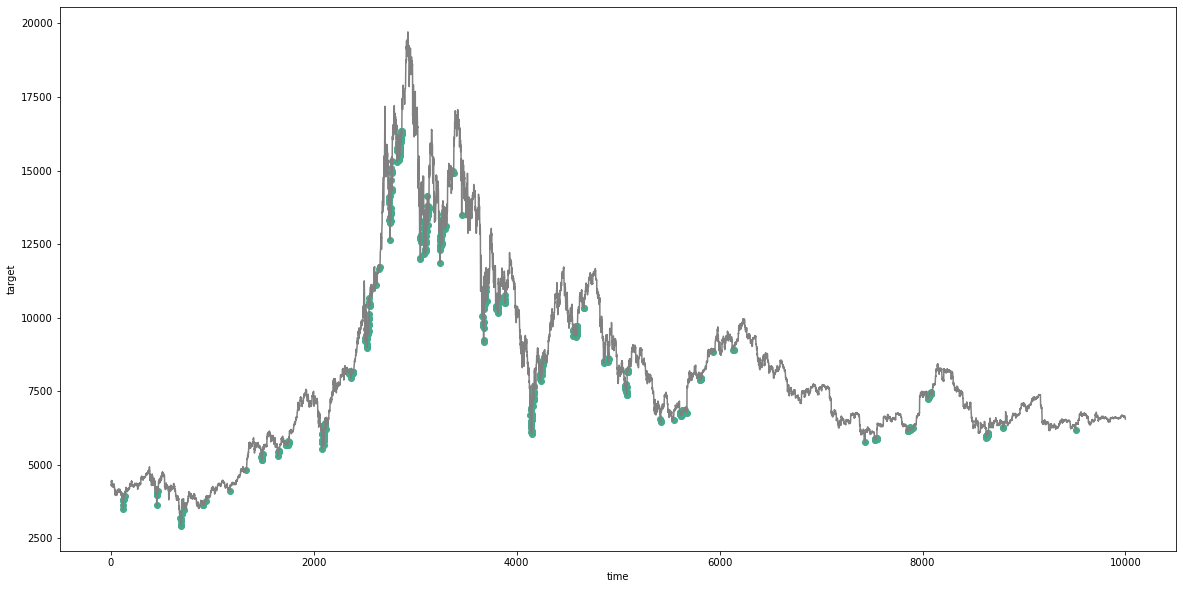

In [20]:
fig,ax = plt.subplots(figsize=(20, 10))
ax.scatter(range(10000),
           dp.scatter_results,
            color="#43aa8b")
# ax.axhline(y=0, color='darkgreen', linestyle='-')
ax.set_xlabel("time")
ax.set_ylabel("target")

# ax.tick_params(labelbottom=False)    
# ax.axes.xaxis.set_visible(False)

# ax2=ax.twinx()
ax.plot(dp.close,
         color="grey")

# ax.set_ylabel("close")
# fig.legend(["a", "b", "c", "d"])
plt.show()